**This notebook shows how to run inference with MIPHEI-vit on a preprocessed dataset** that includes target images and nuclei segmentation masks.

We use the **ORION test set** as an example. It contains **H&E and multiplex images** on the same restained sections.

**Nuclei segmentation masks were generated using CellPose on the DAPI channel.** These masks are used to extract **single-cell predictions** by computing the **mean predicted mIF expression** within each cell. A **logistic regression model**, trained on the ORION training set, is then applied to classify cell types.

![Inference Pipeline](inference_pipeline.png)
**Figure:** Inference pipeline used for cell type prediction.

**Use this notebook to visualize how our model works on the ORION dataset.** If you want to run inference on your own images, please refer to the `inference.ipynb` notebook.

# Import Packages

In [1]:
import pyvips
from omegaconf import OmegaConf
from cellpose import models
import pandas as pd
import json
import albumentations as A
from pathlib import Path
import torch
from safetensors.torch import load_file
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from src.dataset import get_input_mean_std, get_width_height, get_effective_width_height, NormalizationLayer,\
        TileImg2ImgSlideDataset
from src.generators import get_generator
from src.utils import MeanCellExtrator

def validate_load_info(load_info):
    """
    Validates the result of model.load_state_dict(..., strict=False).

    Raises:
        ValueError if unexpected keys are found,
        or if missing keys are not related to the allowed encoder modules.
    """
    # 1. Raise if any unexpected keys
    if load_info.unexpected_keys:
        raise ValueError(f"Unexpected keys in state_dict: {load_info.unexpected_keys}")

    # 2. Raise if any missing keys are not part of allowed encoder modules
    for key in load_info.missing_keys:
        if ".lora" in key:
            raise ValueError(f"Missing LoRA checkpoint in state_dict: {key}")
        elif not any(part in key for part in ["encoder.vit.", "encoder.model."]):
            raise ValueError(f"Missing key in state_dict: {key}")

/opt/local/anaconda3/envs/miphe/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/local/anaconda3/envs/miphe/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/local/anaconda3/envs/miphe/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.morphology import binary_dilation, disk

def inference_cellpose(x, cellpose_model, preprocess_input_fn, radius=None):
    x_cellpose = np.uint8(preprocess_input_fn.unormalize(x.permute((1, 2, 0)).numpy()))
    nuclei_mask, _, _, _ = cellpose_model.eval(
            x_cellpose,
            channels=[0, 0],
            diameter=None,
            min_size=15,
            normalize=True,
            invert=True,
            flow_threshold=0.4,
    )

    if radius is not None:
        # watershed nuclei expansion
        binary = nuclei_mask > 0
        dilated_mask = binary_dilation(binary, footprint=disk(radius))
        distance = ndi.distance_transform_edt(~binary)
        nuclei_mask = watershed(-distance, markers=nuclei_mask, mask=dilated_mask, watershed_line=False)
    return nuclei_mask


def inference_cellpose_batch(x, cellpose_model, preprocess_input_fn, radius=None):
    x_cellpose = np.uint8(preprocess_input_fn.unormalize(x.permute((0, 2, 3, 1)).numpy()))
    nuclei_mask, _, _, _ = cellpose_model.eval(
                list(x_cellpose),
                channels=[0, 0],
                diameter=None,
                min_size=15,
                normalize=True,
                invert=True,
                flow_threshold=0.4,
        )

    if radius is not None:
        for i in range(len(nuclei_mask)):
            binary = nuclei_mask[i] > 0
            dilated_mask = binary_dilation(binary, footprint=disk(radius))
            distance = ndi.distance_transform_edt(~binary)
            nuclei_mask[i] = watershed(-distance, markers=nuclei_mask[i], mask=dilated_mask, watershed_line=False)

    nuclei_mask = np.stack(nuclei_mask, axis=0)
    return nuclei_mask


def create_nuclei_types(nuclei_mask_torch, cell_predictions, cell_ids):
    height, width = nuclei_mask_torch.shape[2], nuclei_mask_torch.shape[3]
    n_cell_types = cell_predictions.shape[-1]
    nuclei_types_torch = torch.zeros((1, n_cell_types, height, width), dtype=torch.bool)

    for idx_class in range(n_cell_types):
        cell_ids_class = cell_ids[cell_predictions[..., idx_class]]
        nuclei_types_torch[:, idx_class] = torch.isin(nuclei_mask_torch, cell_ids_class).cpu()
    return nuclei_types_torch

# ROI Inference

In [3]:
DATASET_NAME = "hemit" # hemit or orion

if DATASET_NAME not in ["orion", "hemit"]:
    raise ValueError("DATASET_NAME should be either 'orion' or 'hemit'")

checkpoint_dir = "/root/workdir/checkpoints_paper/vitmatte_hotpimus_lora" # select the checkpoint directory
MPP = 0.5

In [4]:
checkpoint_path = str(Path(checkpoint_dir) / "model.safetensors")
config_path = str(Path(checkpoint_dir) / "config.yaml")

cfg = OmegaConf.load(config_path)
dataset_config_path = f"../configs/data/{DATASET_NAME}.yaml"
cfg_data = OmegaConf.load(dataset_config_path)
for key in ["slide_dataframe_path", "train_dataframe_path", "val_dataframe_path", "test_dataframe_path", "channel_stats_path"]:
    if key in cfg_data.data:
        cfg.data[key] = cfg_data.data[key]

slide_dataframe = pd.read_csv(cfg.data.slide_dataframe_path)
dataframe = pd.read_csv(cfg.data.test_dataframe_path)
if DATASET_NAME == "hemit":
    dataframe = pd.concat((dataframe,
                          pd.read_csv(cfg.data.val_dataframe_path))) # val also test for our model

width, height = get_width_height(dataframe)
width, height = get_effective_width_height(width, height, train=True)

spatial_augmentations = A.Compose([
    A.CenterCrop(width=width, height=height),
], additional_targets={"image_target": "image", "nuclei": "image"})

nc_out = len(cfg.data.targ_channel_names)
nc_in = 3
print("{} width / {} height".format(width, height))
print("{} inputs channels / {} output channels".format(nc_in, nc_out))

with open(Path("..") / cfg.data.channel_stats_path, "r") as f:
    channel_stats = json.load(f)

channel_stats_rgb = get_input_mean_std(cfg, channel_stats["RGB"])
preprocess_input_fn = NormalizationLayer(channel_stats_rgb, mode="he")

channel_names = cfg.data.targ_channel_names
channel_names_targ = channel_names if DATASET_NAME == "orion" else ["Pan-CK", "CD3", "Dapi"]
targ_channel_idxs = [channel_stats[channel_name]["idx_channel"] \
                        for channel_name in channel_names_targ]
idx_dapi = 0 if DATASET_NAME == "orion" else 2

dataset = TileImg2ImgSlideDataset(
    dataframe=dataframe, preprocess_input_fn=preprocess_input_fn,
    targ_channel_idxs=targ_channel_idxs,
    spatial_augmentations=spatial_augmentations, return_nuclei=True)

1024 width / 1024 height
3 inputs channels / 16 output channels
he [[180.341865 147.575895 179.422335]] [[54.030165 58.679835 45.266835]]


In [ ]:
torch.cuda.empty_cache()

cellpose_model = models.Cellpose(model_type="nuclei", gpu=True)
mean_extractor = MeanCellExtrator().cuda()
n_marker = len(channel_names_targ) - 1
logreg = torch.nn.Linear(15, n_marker)
logreg_ckpt_name = "logreg.pth" if DATASET_NAME == "orion" else "hemit_logreg.pth"
logreg_state_dict = torch.load(str(Path(checkpoint_path).parent / logreg_ckpt_name), map_location="cpu")
logreg.load_state_dict(logreg_state_dict)
logreg.eval().cuda()


if DATASET_NAME == "hemit":
    model_width = width // 2
else:
    model_width = width
# load MIPHEI-vit model
generator = get_generator(cfg.model.model_name, model_width, nc_in, nc_out, cfg)
state_dict = load_file(checkpoint_path, device="cpu")

load_info = generator.load_state_dict(state_dict, strict=False)
validate_load_info(load_info)
generator = generator.eval().cuda().half()

In [6]:
radius = 1 / MPP if MPP is not None else None

In [7]:
idx_tile = np.random.randint(len(dataset))
data = dataset[idx_tile]
x = data["image"]
image = np.uint8(preprocess_input_fn.unormalize(x.permute((1, 2, 0)).numpy()))
nuclei_mask = inference_cellpose(x, cellpose_model, preprocess_input_fn, radius=radius)
nuclei_mask_torch = torch.from_numpy(nuclei_mask).unsqueeze(0).unsqueeze(0).cuda().long()

x = x.unsqueeze(0)

with torch.inference_mode():
    if DATASET_NAME == "hemit":
        x = torch.nn.functional.interpolate(x, (model_width, model_width), mode="bilinear")
    pred = generator(x.half().cuda())
    if DATASET_NAME == "hemit":
        pred = torch.nn.functional.interpolate(pred, (width, height), mode="bilinear")
    pred = pred.clamp(-0.9, 0.9)
    pred_cell_means, _, cell_ids = mean_extractor(pred.float(), None, nuclei_mask_torch)
    pred_cell_means = (pred_cell_means + 0.9) / 1.8 * 255
    cell_predictions = torch.sigmoid(logreg(pred_cell_means[..., 1:])) > 0.5
    nuclei_types_torch = create_nuclei_types(nuclei_mask_torch, cell_predictions, cell_ids).cpu()
    cell_ids = cell_ids.cpu()
    pred = (pred + 0.9) / 1.8
    pred = (pred * 255).to(torch.uint8).cpu()

pred = pred[0].numpy()
cell_ids = cell_ids.numpy()
nuclei_types_torch = nuclei_types_torch[0].numpy()
target = data["target"].numpy()

Text(0.5, 1.0, 'H&E image with Cellpose nuclei mask')

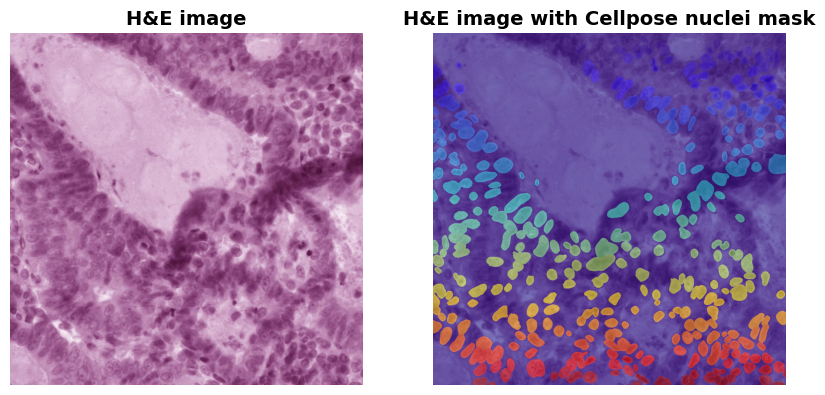

In [8]:
fig, axis = plt.subplots(1, 2, figsize=(10, 10))
axis[0].imshow(image)
axis[0].axis("off")
axis[0].set_title("H&E image", fontsize=14, fontweight="bold")

axis[1].imshow(image)
axis[1].imshow(nuclei_mask, alpha=0.5, cmap="jet")
axis[1].axis("off")
axis[1].set_title("H&E image with Cellpose nuclei mask", fontsize=14, fontweight="bold")

/tmp/ipykernel_18453/3661050938.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


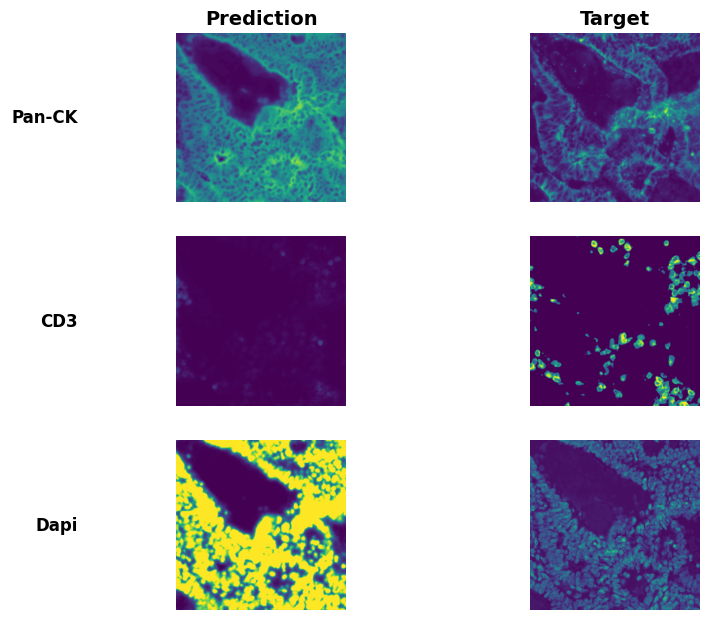

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

if DATASET_NAME == "hemit":
    map_index = [14, 10, 0] # Pan-CK, CD3e, Hoechst
    pred_map = pred[map_index]
else:
    pred_map = pred

n_channels = len(channel_names_targ)
fig = plt.figure(figsize=(10, 2.5 * n_channels))
gs = gridspec.GridSpec(n_channels, 3, width_ratios=[0.2, 1, 1], wspace=0.05)

for i in range(n_channels):
    # Label column
    ax_label = fig.add_subplot(gs[i, 0])
    ax_label.axis("off")
    ax_label.text(1.0, 0.5, channel_names_targ[i],
                  va='center', ha='right', fontsize=12, fontweight='bold')

    # Prediction
    ax_pred = fig.add_subplot(gs[i, 1])
    ax_pred.imshow(pred_map[i], vmin=0, vmax=100, cmap='viridis')
    ax_pred.axis("off")
    if i == 0:
        ax_pred.set_title("Prediction", fontsize=14, fontweight="bold")

    # Target
    ax_target = fig.add_subplot(gs[i, 2])
    ax_target.imshow(target[i], vmin=0, vmax=100, cmap='viridis')
    ax_target.axis("off")
    if i == 0:
        ax_target.set_title("Target", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Target CD3 mIF')

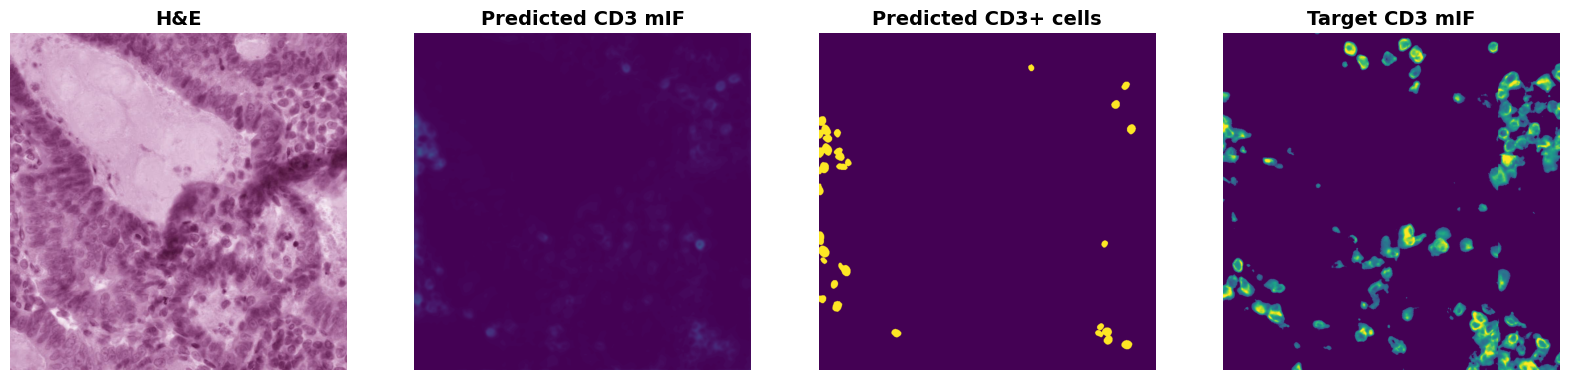

: 

In [ ]:
channel_name_vis = "CD3"

idx_channel = channel_names_targ.index(channel_name_vis)
idx_nuclei_type = idx_channel - 1 if DATASET_NAME == "orion" else idx_channel


fig, axis = plt.subplots(1, 4, figsize=(20, 20))
axis[0].imshow(image)
axis[0].axis("off")
axis[0].set_title("H&E", fontsize=14, fontweight="bold")

axis[1].imshow(pred_map[idx_channel], vmin=0, vmax=100)
axis[1].axis("off")
axis[1].set_title(f"Predicted {channel_name_vis} mIF", fontsize=14, fontweight="bold")

axis[2].imshow(nuclei_types_torch[idx_nuclei_type])
axis[2].axis("off")
axis[2].set_title(f"Predicted {channel_name_vis}+ cells", fontsize=14, fontweight="bold")

axis[3].imshow(target[idx_channel], vmin=0, vmax=100)
axis[3].axis("off")
axis[3].set_title(f"Target {channel_name_vis} mIF", fontsize=14, fontweight="bold")

# Batch ROI inference

In [19]:
num_workers = 6
batch_size = 4
device = "cpu"
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, pin_memory=device!="cpu",
    shuffle=False, drop_last=False, num_workers=num_workers
)

In [20]:
for batch in tqdm(dataloader, total=len(dataloader)):
    x = batch["image"]
    image = np.uint8(preprocess_input_fn.unormalize(x.permute((0, 2, 3, 1)).numpy()))
    nuclei_mask = inference_cellpose_batch(x, cellpose_model, preprocess_input_fn, radius=radius)
    nuclei_mask_torch = torch.from_numpy(nuclei_mask).unsqueeze(1).cuda().long()


    with torch.inference_mode():
        if DATASET_NAME == "hemit":
            x = torch.nn.functional.interpolate(x, (model_width, model_width), mode="bilinear")
        pred = generator(x.half().cuda())
        if DATASET_NAME == "hemit":
            pred = torch.nn.functional.interpolate(pred, (width, height), mode="bilinear")
        pred = pred.clamp(-0.9, 0.9)

        nuclei_types_torch = []
        for i in range(pred.shape[0]):
            pred_cell_means, _, cell_ids = mean_extractor(pred[[i]].float(), None, nuclei_mask_torch[[i]])
            pred_cell_means = (pred_cell_means + 0.9) / 1.8 * 255
            pred_cell_means = torch.cat([pred_cell_means[:, :idx_dapi],
                                 pred_cell_means[:, idx_dapi+1:]], dim=-1) # trick to remove dapi
            cell_predictions = torch.sigmoid(logreg(pred_cell_means)) > 0.5
            nuclei_types_torch.append(create_nuclei_types(nuclei_mask_torch[[i]], cell_predictions, cell_ids).cpu()[0])
            cell_ids = cell_ids.cpu()
        nuclei_types_torch = torch.stack(nuclei_types_torch, dim=0)

        pred = (pred + 0.9) / 1.8
        pred = (pred * 255).to(torch.uint8).cpu()
    break

  0%|          | 0/2738 [00:02<?, ?it/s]
